# Generalized response

In [2]:
'''
 Load data. Input files defined in yaml files (destest_bpz.yaml, destest_metacal.yaml,destest_gold.yaml)
 It requires destest : 
 https://github.com/des-science/destest
 
 
 catalogs (to be specified in the yaml files):
 
 Latest version '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18.h5'
 Latest subsampled version (for quick tests): '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18_subsampled.h5'
 
 I didn't manage to run the destest Calibrator. This means that if you directly load R1 and R2 from the catalog,
 they are only the respones of the sample and neglect the response of the selection (which is usually few %).
 The solution I got was to load the columns without selection (uncut=True)
 and apply the response and selection by myself.
'''


import os
import sys

# ******************************************************************
#                              INPUT
# ******************************************************************
nside = 1024  
z_min = 0
z_max = 5000


# output folders ***************
name_folder_x= '/global/cscratch1/sd/mgatti/Cosmic_shear/response_fmastercat_04_20_100/'  

if not os.path.exists(name_folder_x):
    os.mkdir(name_folder_x)

print ("done")

done


# load catalog

In [3]:
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing


import matplotlib.pyplot as plt
import numpy as np
import pyfits as pf
import healpy as hp
import h5py as h5

import os
import sys


bins = ['all']
nside = 1024



# read File *******

File_data = "/project/projectdirs/des/www/y3_cats/Y3_mastercat_03_31_20.h5"
master = h5.File(File_data,'r')

ra_master = np.array(master['catalog']['metacal']['unsheared']['ra'])
dec_master =  np.array(master['catalog']['metacal']['unsheared']['dec'])

# gold + mcal
select_all  = np.array(master['index']['select'])  # photo + gold + mcal
all_a = np.arange(len(ra_master ))
mask  = np.in1d(all_a ,np.array(master['index']['select']))
mask_1p  = np.in1d(all_a ,np.array(master['index']['select_1p']))
mask_1m  = np.in1d(all_a ,np.array(master['index']['select_1m']))
mask_2p  = np.in1d(all_a ,np.array(master['index']['select_2p']))
mask_2m  = np.in1d(all_a ,np.array(master['index']['select_2m']))

mmm = dict()

cat = dict()
snr= np.array(master['catalog']['metacal']['unsheared']['snr'])
g1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])
g2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])
g1p = np.array(master['catalog']['metacal']['sheared_1p']['e_1'])#[select_metacal]
g1m = np.array(master['catalog']['metacal']['sheared_1m']['e_1'])#[select_metacal]
g2p = np.array(master['catalog']['metacal']['sheared_2p']['e_2'])#[select_metacal]
g2m = np.array(master['catalog']['metacal']['sheared_2m']['e_2'])#[select_metacal]
w = np.array(master['catalog']['metacal']['unsheared']['weight'])
w1p = np.array(master['catalog']['metacal']['sheared_1p']['weight'])
w1m = np.array(master['catalog']['metacal']['sheared_1m']['weight'])
w2p = np.array(master['catalog']['metacal']['sheared_2p']['weight'])
w2m = np.array(master['catalog']['metacal']['sheared_2m']['weight'])


master.close()

# this allows to select all the galaxies. needs to be changed in the future
z_column = 'snr'
sample_dict = {z_column: snr}
sample_dict['ra']= ra_master
sample_dict['dec']=dec_master



# jackknife

 Bin:  0 5000
done


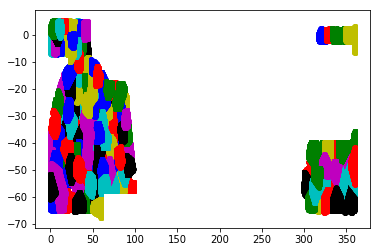

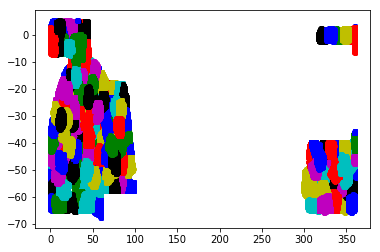

done


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import kmeans_radec
import os
from scipy import spatial
from kmeans_radec import KMeans, kmeans_sample
import sys
import pickle

# **************************************
n_jck = 150

# **************************************

def distance_calc(label, ra_m, dec_m, jk_m, njk, centers):
    '''
    based on the maximum angular scale probed by the cross-correlation,
    computes which jackknife regions should be included in the computation
    '''

    import timeit
    max_dist_region1 = np.zeros(njk)

    # convert radec to xyz
    cosdec = np.cos(dec_m)
    aJx_u = cosdec * np.cos(ra_m)
    aJy_u = cosdec * np.sin(ra_m)
    aJz_u = np.sin(dec_m)

    start = timeit.default_timer()
    update_progress(0.)
    for i in range(njk):
        if len(ra_m[jk_m == i]) == 0 or len(dec_m[jk_m == i]) == 0:
            max_dist_region1[i] = 0.
        else:

            ra_c, dec_c = centers[i]
            cosdec = np.cos(dec_c)
            aJx_r = cosdec * np.cos(ra_c)
            aJy_r = cosdec * np.sin(ra_c)
            aJz_r = np.sin(dec_c)

            tree_m = spatial.cKDTree(np.c_[aJx_u[jk_m == i], aJy_u[jk_m == i], aJz_u[jk_m == i]])

            max_dist_m, index_dist = tree_m.query([aJx_r, aJy_r, aJz_r], k=len(ra_m[jk_m == i]))

            ra_new = ra_m[jk_m == i]
            dec_new = dec_m[jk_m == i]

            if (len(ra_m[jk_m == i]) == 1):
                max_dist_region1[i] = dist_cent_2(ra_c, dec_c, ra_new[index_dist], dec_new[index_dist])
            else:
                max_dist_region1[i] = dist_cent_2(ra_c, dec_c, ra_new[index_dist[-1]], dec_new[index_dist[-1]])
        update_progress(np.float(i + 1) / np.float(njk), timeit.default_timer(), start)

    save_obj(label, max_dist_region1)


def dist_cent_2(ra1, dec1, ra2, dec2):
    todeg = np.pi / 180.
    ra1 = ra1 * todeg
    ra2 = ra2 * todeg
    dec1 = dec1 * todeg
    dec2 = dec2 * todeg

    cos = np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
    return np.arccos(cos) / todeg

def update_progress(progress, elapsed_time=0, starting_time=0):
    import time

    barLength = 10  # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength * progress))

    if progress * 100 > 1. and elapsed_time > 0:
        remaining = ((elapsed_time - starting_time) / progress) * (1. - progress)
        text = "\rPercent: [{0}] {1:.2f}% {2}  - elapsed time: {3} - estimated remaining time: {4}".format(
            "#" * block + "-" * (barLength - block), progress * 100, status,
            time.strftime('%H:%M:%S', time.gmtime(elapsed_time - starting_time)),
            time.strftime('%H:%M:%S', time.gmtime(remaining)))
    else:
        text = "\rPercent: [{0}] {1:.2f}% {2}".format("#" * block + "-" * (barLength - block), progress * 100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

    
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)#, encoding='latin1')

def convert_to_pix_coord(ra, dec, nside=1024):
    """
    Converts RA,DEC to hpix coordinates
    """

    theta = (90.0 - dec) * np.pi / 180.
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=False)

    return pix


def IndexToDeclRa(index, nside):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index)
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)

def jaccknife_regions(ra,dec,number_of_regions,label_jck = None, centers_jck = None, v = False):
    new_cat=np.array(zip(ra, dec))
    A=new_cat[np.random.randint(new_cat.shape[0],size=20000),:]
    
    if not v:
        centers_jck= kmeans_radec.kmeans_sample(A,number_of_regions,maxiter=100,tol=1e-05,verbose=0)
        np.savetxt(label_jck, centers_jck.centers)
        centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
        _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
        return centers_tree, hpix, centers_jck.centers[:,[0,1]]   
    
    centers_tree = spatial.cKDTree(centers_jck[:,[0,1]])
    _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
    return centers_tree, hpix, centers_jck[:,[0,1]]

def negotiate(jkfield,nside,mask,theta,phi,nmaxboderiter):
            sortjk = np.argsort(jkfield)
            jkcounts = np.bincount(jkfield)  
            npix = hp.nside2npix(nside)  
            pixel2indx = np.zeros(npix,dtype=int)        # ipix to index in the mask-only-array
            pixel2indx = -1*pixel2indx                   # -1 : pixel has no indx assignded
            pixel2indx[mask]=np.array(range(len(pixel2indx[mask])))
            for mute in range(nmaxboderiter):  # iterate over border negotiation

                ichange = 0
                irare = 0
                sortjk = np.argsort(jkfield)
                for indx in sortjk:
                    jk1 = jkfield[indx]
                    ipixarr = hp.get_all_neighbours(nside, theta[indx],phi[indx]) # 8 neighbours, will use only 4      
        
                    for j in range(8):  # 

                        ipix2 = ipixarr[j] 
                        if (ipix2 < 0) : 
                            #rare pixel with no S W N E neighbour found, then ok
                            irare=irare+1
                            continue 
            
                        indx2 = pixel2indx[ipix2]
                        jk2 = jkfield[indx2] 
            
                    #keep central pixel, change adjacent if appropiate, i.e, 
                    #expand if adjacent pixels are from larger jk regions
                        if ( jkcounts[jk1] < jkcounts[jk2]):
                            ichange = ichange+1
                            jkfield[indx2] = jk1
                            jkcounts[jk2]=jkcounts[jk2]-1
                            jkcounts[jk1]=jkcounts[jk1]+1
            return jkfield
        
        


# only on one bin


print " Bin: ",z_min,z_max
name_foder =name_folder_x+'_{0}_{1}/'.format(z_min,z_max)

if not os.path.exists(name_foder):    
    os.mkdir(name_foder)


path_info = name_foder +'info_PARTIAL_{3}'.format(0,500,nside,n_jck) # load 
label_jck = name_foder +'jck_centers_data_PARTIAL_{3}.txt'.format(z_min,z_max,nside,n_jck)
label_dist = name_foder +'distance_PARTIAL_{3}.txt'.format(z_min,z_max,nside,n_jck)
hpix_name = name_foder +'hpix_PARTIAL_m1_{3}.fits'.format(z_min,z_max,nside,n_jck)


if os.path.exists(path_info+'.pkl'):
    info = load_obj(path_info)
else:   

    selection_z = np.zeros(len(sample_dict['ra']))
    selection_z += 4
    select_bin_1 = (sample_dict[z_column] > z_min) & (sample_dict[z_column] < z_max)
    selection_z[select_bin_1] += 1
    mask_1_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])
    pix = convert_to_pix_coord(sample_dict['ra'][mask & mask_1_bin], sample_dict['dec'][mask & mask_1_bin], nside=nside)
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_map = np.zeros(hp.nside2npix(nside))
    n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))

    mask_sims = n_map>0.
    info = dict()
    info.update({'mask_sims' : mask_sims})


    # define jackknife regions **********************
    area = np.array(range(hp.nside2npix(nside)))[mask_sims]
    dec,ra = IndexToDeclRa(area, nside)



    if  os.path.exists(label_jck):
        centers=np.array(np.loadtxt(label_jck)) 
        centers_tree, hpix, centers = jaccknife_regions(ra,dec,n_jck,label_jck, centers, v = True)
    else:
        centers_tree, hpix, centers = jaccknife_regions(ra,dec,n_jck,label_jck)

    info.update({'hpix' : hpix})
    info.update({'ra' : ra})
    info.update({'dec' : dec})
    info.update({'centers' : centers})
    info.update({'n_jck' : n_jck})


    new_cat=np.array(zip(ra, dec))

    #1st iteration:
    A=new_cat[np.random.randint(new_cat.shape[0],size=50000),:]
    centers_jck= kmeans_radec.kmeans_sample(A,n_jck,maxiter=100,tol=1e-05,verbose=0)
    def IndexToDeclRa1(index, nside):
            theta,phi=hp.pixelfunc.pix2ang(nside ,index)
            return -np.degrees(theta-np.pi/2.),np.degrees(phi),theta,phi
    dec,ra,theta,phi = IndexToDeclRa1(area, nside)

    jkfield = centers_jck.find_nearest(new_cat)
    jkfield1 = negotiate(jkfield,nside,mask_sims,theta,phi,7)

    info.update({'hpix_f' :jkfield1})
    info.update({'centers_f' :centers_jck})

    save_obj(path_info,info)



    
    
print ('done')

# plot jackknife regions in case ********************
color_i=[]
for gg in range(1000):
    color_i.append('b')
    color_i.append('g')
    color_i.append('r')
    color_i.append('c')
    color_i.append('m')
    color_i.append('y')
    color_i.append('k')

fig= plt.figure()
ax = fig.add_subplot(111)
for j in range(len(np.unique(info['hpix']))):
    mask2=info['hpix']==j
    plt.plot(info['ra'][mask2], info['dec'][mask2], 'o', ms=4, alpha=1., color=color_i[j])
plt.show()  
for j in range(len(np.unique(info['hpix']))):
    mask2=info['hpix_f']==j
    plt.plot(info['ra'][mask2], info['dec'][mask2], 'o', ms=4, alpha=1., color=color_i[j])
plt.show()  

# load hpix assignment
import pyfits as pf
try:
    if os.path.exists(hpix_name):
        hpix = pf.open(hpix_name)
        hpix = hpix[1].data['hpix']
    else:
        bbb = np.vstack([np.array(sample_dict['ra']).T,
                         np.array(sample_dict['dec']).T]).T
        from scipy import spatial
        from astropy.table import Table
        _, hpix =  (spatial.cKDTree(info['centers'])).query(bbb)

        fits_f = Table()
        fits_f['hpix'] = hpix
        fits_f.write(hpix_name)

except ValueError:
        print('Jackknife centers file missing')
        
print 'done'


if not os.path.exists(label_dist + '.pkl'):
        distance_calc(label_dist, info['ra'], info['dec'], info['hpix'], n_jck, info['centers'])
else:
        pass



# Compute Response (linear)

In [5]:
import numpy as np
import os
        
# input params ******************************************

Nbins = 20

min_theta = 2.5/60.
max_theta = 250./60.
number_of_cores = 64
bin_slope = 0.001


rewrite = False
runs_path = dict()
count = 0

conf = {'nbins': Nbins,
            'min_sep': min_theta,
            'max_sep': max_theta,
            'sep_units': 'degrees',
            'bin_slop': bin_slope,
            'nodes': number_of_cores  # parameter for treecorr
            }

 Bin:  0 5000


/global/homes/m/mgatti/.conda/envs/myenv/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


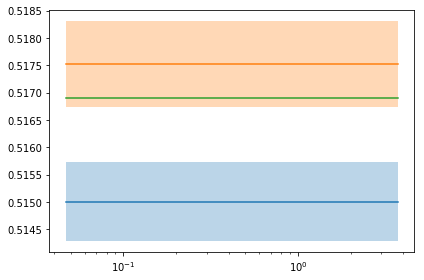

In [11]:
rewrite = False


#0.7176500844536258
#0.7193847860454086

print " Bin: ",z_min,z_max
name_foder = name_folder_x+'_{0}_{1}/'.format(z_min,z_max)
if not os.path.exists(name_foder):    
    os.mkdir(name_foder)    
if rewrite or not os.path.exists(name_foder+'_normal_response.pkl'):

    selection_z = np.zeros(len(sample_dict['ra']))
    selection_z += 4
    select_bin_1 = (sample_dict[z_column] > z_min) & (sample_dict[z_column] < z_max)
    selection_z[select_bin_1] += 1
    mask_1_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])
    mask_2_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])
       
    R11_12_j = np.zeros(n_jck)
    R22_12_j = np.zeros(n_jck)
    
    R_tot_j = np.zeros(n_jck)
    
    
    dgamma = 2. * 0.01
    

    
    R11_1 = (np.sum((w1p*g1p)[mask & mask_1_bin])/np.sum(w1p[mask& mask_1_bin]) - 
             np.sum((w1m*g1m)[mask & mask_1_bin])/np.sum(w1m[mask& mask_1_bin]) + 
             np.sum((w*g1)[mask_1p & mask_1_bin])/np.sum(w[mask_1p & mask_1_bin]) - 
             np.sum((w*g1)[mask_1m & mask_1_bin])/np.sum(w[mask_1m & mask_1_bin])) / dgamma
    
    R22_1 = (np.sum((w2p*g2p)[mask & mask_1_bin])/np.sum(w2p[mask & mask_1_bin]) - 
             np.sum((w2m*g2m)[mask & mask_1_bin])/np.sum(w2m[mask & mask_1_bin]) + 
             np.sum((w*g2)[mask_2p & mask_1_bin])/np.sum(w[mask_2p & mask_1_bin]) - 
             np.sum((w*g2)[mask_2m & mask_1_bin])/np.sum(w[mask_2m & mask_1_bin])) / dgamma

    R11_2 = (np.sum((w1p*g1p)[mask & mask_2_bin])/(np.sum(w1p[mask & mask_2_bin])) - 
             np.sum((w1m*g1m)[mask & mask_2_bin])/(np.sum(w1m[mask & mask_2_bin])) + 
             np.sum((w*g1)[mask_1p & mask_2_bin])/(np.sum(w[mask_1p & mask_2_bin])) - 
             np.sum((w*g1)[mask_1m & mask_2_bin])/(np.sum(w[mask_1m & mask_2_bin]))) / dgamma
    
    
    R22_2 = (np.sum((w2p*g2p)[mask & mask_2_bin])/np.sum(w2p[mask & mask_2_bin]) - 
             np.sum((w2m*g2m)[mask & mask_2_bin])/np.sum(w2m[mask & mask_2_bin]) + 
             np.sum((w*g2)[mask_2p & mask_2_bin])/np.sum(w[mask_2p & mask_2_bin]) - 
             np.sum((w*g2)[mask_2m & mask_2_bin])/np.sum(w[mask_2m & mask_2_bin])) / dgamma
    
    print (R11_1+R22_1)/2.,0.7176500844536258
    print (R22_2+R22_1)/2.,0.7193847860454086
    R_tot = (R11_1+R22_1)*(R22_2+R22_1)/4.

    print (R11_1+R22_1)/2.,0.7176500844536258
    print (R22_2+R22_1)/2.,0.7193847860454086
    R_tot = (R11_1+R22_1)*(R22_2+R22_1)/4.
    h=0
    def compute_response_r(j):
     if not os.path.exists(name_foder+"/"+str(j)+".pkl"):
    
        print j
        mask_j = hpix != j
        dgamma = 2. * 0.01
        
    # parallelize here *********
        R11_12_j[j] = (((np.sum((g1p*w1p)[mask & mask_1_bin&mask_j])/np.sum(w1p[mask & mask_1_bin&mask_j]) - 
                         np.sum((g1m*w1m)[mask & mask_1_bin&mask_j])/np.sum(w1m[mask & mask_1_bin&mask_j]) + 
                         np.sum((w*g1)[mask_1p & mask_1_bin&mask_j])/np.sum(w[mask_1p & mask_1_bin&mask_j]) - 
                         np.sum((w*g1)[mask_1m & mask_1_bin&mask_j])/np.sum(w[mask_1m & mask_1_bin&mask_j])) / dgamma)*
                       ((np.sum((g1p*w1p)[mask & mask_2_bin&mask_j])/np.sum(w1p[mask & mask_2_bin&mask_j]) - 
                         np.sum((g1m*w1m)[mask & mask_2_bin&mask_j])/np.sum(w1m[mask & mask_2_bin&mask_j]) + 
                         np.sum((w*g1)[mask_1p & mask_2_bin&mask_j])/np.sum(w[mask_1p & mask_2_bin&mask_j]) - 
                         np.sum((w*g1)[mask_1m & mask_2_bin&mask_j])/np.sum(w[mask_1m & mask_2_bin&mask_j])) / dgamma))
        
        
        R22_12_j[j] = (((np.sum((g2p*w2p)[mask & mask_1_bin&mask_j])/np.sum(w2p[mask & mask_1_bin&mask_j]) - 
                         np.sum((g2m*w2m)[mask & mask_1_bin&mask_j])/np.sum(w2m[mask & mask_1_bin&mask_j]) + 
                         np.sum((w*g2)[mask_2p & mask_1_bin&mask_j])/np.sum(w[mask_2p & mask_1_bin&mask_j]) - 
                         np.sum((w*g2)[mask_2m & mask_1_bin&mask_j])/np.sum(w[mask_2m & mask_1_bin&mask_j])) / dgamma)*
                       ((np.sum((g2p*w2p)[mask & mask_2_bin&mask_j])/np.sum(w2p[mask & mask_2_bin&mask_j]) - 
                         np.sum((g2m*w2m)[mask & mask_2_bin&mask_j])/np.sum(w2m[mask & mask_2_bin&mask_j]) + 
                         np.sum((w*g2)[mask_2p & mask_2_bin&mask_j])/np.sum(w[mask_2p & mask_2_bin&mask_j]) - 
                         np.sum((w*g2)[mask_2m & mask_2_bin&mask_j])/np.sum(w[mask_2m & mask_2_bin&mask_j])) / dgamma))

        
        R_tot_j[j] =(((np.sum((w2p*g2p)[mask & mask_1_bin&mask_j])/np.sum((w2p)[mask & mask_1_bin&mask_j]) - 
                       np.sum((g2m*w2m)[mask & mask_1_bin&mask_j])/np.sum((w2m)[mask & mask_1_bin&mask_j]) + 
                       np.sum((w*g2)[mask_2p & mask_1_bin&mask_j])/np.sum((w)[mask_2p & mask_1_bin&mask_j]) - 
                       np.sum((w*g2)[mask_2m & mask_1_bin&mask_j])/np.sum((w)[mask_2m & mask_1_bin&mask_j])) / dgamma)+
                     ((np.sum((g1p*w1p)[mask & mask_1_bin&mask_j])/np.sum((w1p)[mask & mask_1_bin&mask_j]) - 
                       np.sum((w1m*g1m)[mask & mask_1_bin&mask_j])/np.sum((w1m)[mask & mask_1_bin&mask_j]) + 
                       np.sum((w*g1)[mask_1p & mask_1_bin&mask_j])/np.sum((g1)[mask_1p & mask_1_bin&mask_j]) - 
                       np.sum((w*g1)[mask_1m & mask_1_bin&mask_j])/np.sum((g1)[mask_1m & mask_1_bin&mask_j])) / dgamma))*(
        ((np.mean((g1p*w1p)[mask & mask_2_bin&mask_j])/np.sum((w1p)[mask & mask_2_bin&mask_j]) - 
           np.mean((w1m*g1m)[mask & mask_2_bin&mask_j])/np.sum((w1m)[mask & mask_2_bin&mask_j]) + 
           np.mean((w*g1)[mask_1p & mask_2_bin&mask_j])/np.sum((w)[mask_1p & mask_2_bin&mask_j]) - 
           np.mean((w*g1)[mask_1m & mask_2_bin&mask_j])/np.sum((w)[mask_1m & mask_2_bin&mask_j])) / dgamma)*((np.mean((g2p*w2p)[mask & mask_2_bin&mask_j])/np.sum((w2p)[mask & mask_2_bin&mask_j]) - 
           np.mean((g2m*w2m)[mask & mask_2_bin&mask_j])/np.sum((w2m)[mask & mask_2_bin&mask_j]) + 
           np.mean((w*g2)[mask_2p & mask_2_bin&mask_j])/np.sum((w)[mask_2p & mask_2_bin&mask_j]) - 
           np.mean((w*g2)[mask_2m & mask_2_bin&mask_j])/np.sum((w)[mask_2m & mask_2_bin&mask_j])) / dgamma))/4.
           
        save_obj(name_foder+"/"+str(j),[R11_12_j,R22_12_j,R_tot_j])

    run_count = 0
    agents =20
    l1 = range(n_jck)
    with closing(Pool(processes=agents)) as pool:
        pool.map(partial(compute_response_r),l1)
        

    import os   
    sys.path.insert(0, '../Additive/')
    from routines import *
    for h in range(n_jck):
        lsr = load_obj(name_foder+"/"+str(h))
       
        R11_12_j[h],R22_12_j[h],R_tot_j[h] = lsr[0][h],lsr[1][h],lsr[2][h]
        #os.remove(name_foder+"/"+str(h)+".pkl")


    normale_response = dict()
    normale_response.update({'R11_1':R11_1})
    normale_response.update({'R22_1':R22_1})
    normale_response.update({'R11_2':R11_2})
    normale_response.update({'R22_2':R22_2})
    normale_response.update({'R11_12_j':R11_12_j})
    normale_response.update({'R22_12_j':R22_12_j})
    normale_response.update({'R_tot_j':R_tot_j})
    normale_response.update({'R_tot':R_tot})
    save_obj(name_foder+'_normal_response',normale_response)
    print 'done'
else:
    normale_response = load_obj(name_foder+'_normal_response') 
    

min_sep, max_sep, nedges = conf['min_sep'], conf['max_sep'], conf['nbins']+1
th = np.linspace(np.log10(min_sep), np.log10(max_sep), nedges)
theta = 10**np.array([(th[i]+th[i+1])/2 for i in range(len(th)-1)])

R_e1 = np.ones(len(theta))*(normale_response['R11_1']*normale_response['R11_2'])
R_e2 = np.ones(len(theta))*(normale_response['R22_1']*normale_response['R22_2'])
R_tot = np.ones(len(theta))*(normale_response['R_tot'])

dict_R1=covariance_scalar_jck((normale_response['R11_12_j']),n_jck)
dict_R2=covariance_scalar_jck((normale_response['R22_12_j']),n_jck)
dict_R_tot=covariance_scalar_jck((normale_response['R_tot_j']),n_jck)


plt.plot(theta,R_e1)#,label = 'Y1 R e1')

plt.fill_between(theta, R_e1+dict_R1['err'],R_e1-dict_R1['err'], alpha=.3,label = 'Y1 R**2 e1')
#plt.errorbar(theta+theta/10.,R_e2,dict_R2['err'] , label = 'Y1 R e2')
plt.plot(theta,R_e2)#,label = 'Y1 R e1')
plt.fill_between(theta, R_e2+dict_R2['err'],R_e2-dict_R2['err'], alpha=.3,label = 'Y1 R**2 e2')

plt.plot(theta,R_tot)#,label = 'Y1 R e1')
plt.fill_between(theta, R_tot+dict_R_tot['err'],R_tot-dict_R_tot['err'], alpha=.1,label = 'Y1 R**2 (mean)')


plt.xscale('log', nonposy='clip')
plt.show()



# Prepare runs

In [7]:
ra = (sample_dict['ra'])
dec = (sample_dict['dec'])
R_compute=True
if 1==1:
    
    print " Bin: ",z_min,z_max
    name_foder =name_folder_x+'_{0}_{1}/'.format(z_min,z_max)
    outp_fold = name_foder+'/pairs/'
    name_output  = 'y3_sm_'
    if not os.path.exists(name_foder):    
        os.mkdir(name_foder)

    selection_z = np.zeros(len(sample_dict['ra']))
    selection_z += 4
    select_bin_1 = (sample_dict[z_column] > z_min) & (sample_dict[z_column] < z_max)
    selection_z[select_bin_1] += 1
    mask_1_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])
    mask_2_bin = np.array([str(bin(int(selection_z[i]))[4]) == '1' for i in range(len(selection_z))])

    import timeit
    recompute = True

    # RUN cosmic shear *********************************
    
    

    if R_compute:
        
      # compute Response 2 **************************
        print "1"
        

        # legend:
        # x_S_S_e1e1_e2e2
        
        ########################################################################################
        # 4th term - E2
        ########################################################################################
        
        # x_0_0_0_pp ********************
        
        count =0
        print count
        count+=1
        if 1==1:
        
            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w2p[mask & mask_1_bin], w2p[mask & mask_2_bin],
                 g1[mask & mask_1_bin], g2p[mask & mask_1_bin], g1[mask & mask_1_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_0_pp')
            
            path_run  = name_foder+"/_0_0_0_pp_j"
            runs_path[path_run]=path_run
            save_obj(path_run,J)

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w2m[mask & mask_1_bin], w2m[mask & mask_2_bin],
                 g1[mask & mask_1_bin], g2m[mask & mask_1_bin],g1[mask & mask_1_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_0_mm')
            path_run  = (name_foder+'/_0_0_0_mm_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
            print "2"
            
        # x_0_0_0_mp ********************


            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w2m[mask & mask_1_bin], w2p[mask & mask_2_bin],
                 g1[mask & mask_1_bin], g2m[mask & mask_1_bin], g1[mask & mask_2_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_0_mp')

            path_run  = (name_foder+'/_0_0_0_mp_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

            print "3"
        # x_0_0_0_pm ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w2p[mask & mask_1_bin], w2m[mask & mask_2_bin],
                 g1[mask & mask_1_bin], g2p[mask & mask_1_bin], g1[mask & mask_2_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_0_pm')

            path_run  = (name_foder+'/_0_0_0_pm_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
 
        ########################################################################################
        # 4th term - E1
        ########################################################################################

        # x_0_0_pp_0 ********************
            print "4"
            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w1p[mask & mask_1_bin], w1p[mask & mask_2_bin],
                 g1p[mask & mask_1_bin], g2[mask & mask_1_bin], g1p[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_pp_0')

            path_run  = (name_foder+'/_0_0_pp_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


            
        # x_0_0_pm_0 ********************

            print "5"
            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w1p[mask & mask_1_bin], w1m[mask & mask_2_bin],
                 g1p[mask & mask_1_bin], g2[mask & mask_1_bin], g1m[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_pm_0')

            path_run  = (name_foder+'/_0_0_pm_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


        # x_0_0_mp_0 ********************
            print "6"
            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w1m[mask & mask_1_bin], w1p[mask & mask_2_bin],
                 g1m[mask & mask_1_bin], g2[mask & mask_1_bin], g1p[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_pm_0')

            path_run  = (name_foder+'/_0_0_mp_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

 
        # x_0_0_mm_0 ********************
            print "7"
            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], w1m[mask & mask_1_bin], w1m[mask & mask_2_bin],
                 g1m[mask & mask_1_bin], g2[mask & mask_1_bin], g1m[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_mp_0')

            path_run  = (name_foder+'/_0_0_mm_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


            
        ########################################################################################
        # 3rd mixed term E1
        ########################################################################################



        #mixed select.
        # x_1p_0_0p_0 ********************
            print "8"
            J = Jack(conf, label_dist, ra[mask_1p & mask_1_bin], dec[mask_1p & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1p & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1p & mask_1_bin], w1p[mask & mask_2_bin],
                 g1[mask_1p & mask_1_bin], g2[mask_1p & mask_1_bin], g1p[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p_0_0p_0')

            path_run  = (name_foder+'/_1p_0_0p_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        
        # x_1p_0_0m_0 ********************
            print "9"
            J = Jack(conf, label_dist, ra[mask_1p & mask_1_bin], dec[mask_1p & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1p & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1p & mask_1_bin], w1m[mask & mask_2_bin],
                 g1[mask_1p & mask_1_bin], g2[mask_1p & mask_1_bin], g1m[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p_0_0m_0')
   

            path_run  = (name_foder+'/_1p_0_0m_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        # x_1m_0_0p_0 ********************
            print "10"
            J = Jack(conf, label_dist, ra[mask_1m & mask_1_bin], dec[mask_1m & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1m & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1m & mask_1_bin], w1p[mask & mask_2_bin],
                 g1[mask_1m & mask_1_bin], g2[mask_1m & mask_1_bin], g1p[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m_0_0p_0')

            path_run  = (name_foder+'/_1m_0_0p_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)




        # x_1m_0_0m_0 ********************
            print "11"
            J = Jack(conf, label_dist, ra[mask_1m & mask_1_bin], dec[mask_1m & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1m & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1m & mask_1_bin], w1m[mask & mask_2_bin],
                 g1[mask_1m & mask_1_bin], g2[mask_1m & mask_1_bin], g1m[mask & mask_2_bin], g2[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m_0_0m_0')

            path_run  = (name_foder+'/_1m_0_0m_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)



            

        ########################################################################################
        # 3rd mixed term E2
        ########################################################################################



        #mixed select.
        # x_2p_0_0_0p ********************
            print "12"
            J = Jack(conf, label_dist, ra[mask_2p & mask_1_bin], dec[mask_2p & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_2p & mask_1_bin], hpix[mask & mask_2_bin], w[mask_2p & mask_1_bin], w2p[mask & mask_2_bin],
                 g1[mask_2p & mask_1_bin], g2[mask_2p & mask_1_bin], g1[mask & mask_2_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2p_0_0_0p')

            path_run  = (name_foder+'/_2p_0_0_0p_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        
        # x_2p_0_0_0m ********************
            print "13"
            J = Jack(conf, label_dist, ra[mask_2p & mask_1_bin], dec[mask_2p & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_2p & mask_1_bin], hpix[mask & mask_2_bin], w[mask_2p & mask_1_bin], w2m[mask & mask_2_bin],
                 g1[mask_2p & mask_1_bin], g2[mask_2p & mask_1_bin], g1[mask & mask_2_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2p_0_0_0m')

            path_run  = (name_foder+'/_2p_0_0_0m_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)



        # x_2m_0_0_0p ********************
            print "14"
            J = Jack(conf, label_dist, ra[mask_2m & mask_1_bin], dec[mask_2m & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_2m & mask_1_bin], hpix[mask & mask_2_bin], w[mask_2m & mask_1_bin], w2p[mask & mask_2_bin],
                 g1[mask_2m & mask_1_bin], g2[mask_2m & mask_1_bin], g1[mask & mask_2_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2m_0_0_0p')

            path_run  = (name_foder+'/_2m_0_0_0p_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)



        # x_2m_0_0_0m ********************

            J = Jack(conf, label_dist, ra[mask_2m & mask_1_bin], dec[mask_2m & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_2m & mask_1_bin], hpix[mask & mask_2_bin], w[mask_2m & mask_1_bin], w2m[mask & mask_2_bin],
                 g1[mask_2m & mask_1_bin], g2[mask_2m & mask_1_bin], g1[mask & mask_2_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2m_0_0_0m')

            path_run  = (name_foder+'/_2m_0_0_0m_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)





        ########################################################################################
        # 2nd mixed term E1
        ########################################################################################



        #mixed select.
        # x_0_1p_p0_0 ********************


            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1p & mask_2_bin],
                 dec[mask_1p & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1p & mask_2_bin], w1p[mask & mask_1_bin], w[mask_1p & mask_2_bin],
                 g1p[mask & mask_1_bin], g2[mask & mask_1_bin], g1[mask_1p & mask_2_bin], g2[mask_1p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1p_p0_0')

            path_run  = (name_foder+'/_0_1p_p0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        
        # x_0_1p_m0_0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1p & mask_2_bin],
                 dec[mask_1p & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1p & mask_2_bin], w1m[mask & mask_1_bin], w[mask_1p & mask_2_bin],
                 g1m[mask & mask_1_bin], g2[mask & mask_1_bin], g1[mask_1p & mask_2_bin], g2[mask_1p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1p_m0_0')

            path_run  = (name_foder+'/_0_1p_m0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)



        # x_0_1m_p0_0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1m & mask_2_bin],
                 dec[mask_1m & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1m & mask_2_bin], w1p[mask & mask_1_bin], w[mask_1m & mask_2_bin],
                 g1p[mask & mask_1_bin], g2[mask & mask_1_bin], g1[mask_1m & mask_2_bin], g2[mask_1m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1m_p0_0')

            path_run  = (name_foder+'/_0_1m_p0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


        # x_0_1m_m0_0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1m & mask_2_bin],
                 dec[mask_1m & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1m & mask_2_bin], w1m[mask & mask_1_bin], w[mask_1m & mask_2_bin],
                 g1m[mask & mask_1_bin], g2[mask & mask_1_bin], g1[mask_1m & mask_2_bin], g2[mask_1m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1m_m0_0')

            path_run  = (name_foder+'/_0_1m_m0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)



        ########################################################################################
        # 2nd mixed term E2
        ########################################################################################



        #mixed select.
        # x_0_2p_0_p0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_2p & mask_2_bin],
                 dec[mask_2p & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_2p & mask_2_bin], w2p[mask & mask_1_bin], w[mask_2p & mask_2_bin],
                 g1[mask & mask_1_bin], g2p[mask & mask_1_bin], g1[mask_2p & mask_2_bin], g2[mask_2p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_2p_0_p0')

            path_run  = (name_foder+'/_0_2p_0_p0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
            
            
            
        
        # x_0_2p_0_m0 ********************
   

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_2p & mask_2_bin],
                 dec[mask_2p & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_2p & mask_2_bin], w2m[mask & mask_1_bin], w[mask_2p & mask_2_bin],
                 g1[mask & mask_1_bin], g2m[mask & mask_1_bin], g1[mask_2p & mask_2_bin], g2[mask_2p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_2p_0_m0')

            path_run  = (name_foder+'/_0_2p_0_m0_j') 
            runs_path[path_run]=path_run
            save_obj(path_run,J)



        # x_0_2m_0_p0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_2m & mask_2_bin],
                 dec[mask_2m & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_2m & mask_2_bin], w2p[mask & mask_1_bin], w[mask_2m & mask_2_bin],
                 g1[mask & mask_1_bin], g2p[mask & mask_1_bin], g1[mask_2m & mask_2_bin], g2[mask_2m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_2m_0_p0')

            path_run  = (name_foder+'/_0_2m_0_p0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


        # x_0_2m_0_m0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_2m & mask_2_bin],
                 dec[mask_2m & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_2m & mask_2_bin], w2m[mask & mask_1_bin], w[mask_2m & mask_2_bin],
                 g1[mask & mask_1_bin], g2m[mask & mask_1_bin], g1[mask_2m & mask_2_bin], g2[mask_2m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_2m_0_m0')

            path_run  = (name_foder+'/_0_2m_0_m0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)



       ########################################################################################
        # 1st term E1
        ########################################################################################

        

        #mixed select.
        # x_1p_1p_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_1p & mask_1_bin], dec[mask_1p & mask_1_bin], ra[mask_1p & mask_2_bin],
                 dec[mask_1p & mask_2_bin], hpix[mask_1p & mask_1_bin], hpix[mask_1p & mask_2_bin], w[mask_1p & mask_1_bin], w[mask_1p & mask_2_bin],
                 g1[mask_1p & mask_1_bin], g2[mask_1p & mask_1_bin], g1[mask_1p & mask_2_bin], g2[mask_1p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p_1p_0_0')

            path_run  = (name_foder+'/_1p_1p_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        
        # x_1p_1m_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_1p & mask_1_bin], dec[mask_1p & mask_1_bin], ra[mask_1m & mask_2_bin],
                 dec[mask_1m & mask_2_bin], hpix[mask_1p & mask_1_bin], hpix[mask_1m & mask_2_bin], w[mask_1p & mask_1_bin], w[mask_1m & mask_2_bin],
                 g1[mask_1p & mask_1_bin], g2[mask_1p & mask_1_bin], g1[mask_1m & mask_2_bin], g2[mask_1m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p_1m_0_0')

            path_run  = (name_foder+'/_1p_1m_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)



        # x_1m_1p_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_1m & mask_1_bin], dec[mask_1m & mask_1_bin], ra[mask_1p & mask_2_bin],
                 dec[mask_1p & mask_2_bin], hpix[mask_1m & mask_1_bin], hpix[mask_1p & mask_2_bin], w[mask_1m & mask_1_bin], w[mask_1p & mask_2_bin],
                 g1[mask_1m & mask_1_bin], g2[mask_1m & mask_1_bin], g1[mask_1p & mask_2_bin], g2[mask_1p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m_1p_0_0')

            path_run  = (name_foder+'/_1m_1p_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


        # x_1m_1m_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_1m & mask_1_bin], dec[mask_1m & mask_1_bin], ra[mask_1m & mask_2_bin],
                 dec[mask_1m & mask_2_bin], hpix[mask_1m & mask_1_bin], hpix[mask_1m & mask_2_bin], w[mask_1m & mask_1_bin], w[mask_1m & mask_2_bin],
                 g1[mask_1m & mask_1_bin], g2[mask_1m & mask_1_bin], g1[mask_1m & mask_2_bin], g2[mask_1m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m_1m_0_0')

            path_run  = (name_foder+'/_1m_1m_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


       ########################################################################################
        # 1st term E2
        ########################################################################################



        #mixed select.
        # x_2p_2p_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_2p & mask_1_bin], dec[mask_2p & mask_1_bin], ra[mask_2p & mask_2_bin],
                 dec[mask_2p & mask_2_bin], hpix[mask_2p & mask_1_bin], hpix[mask_2p & mask_2_bin], w[mask_2p & mask_1_bin], w[mask_2p & mask_2_bin],
                 g1[mask_2p & mask_1_bin], g2[mask_2p & mask_1_bin], g1[mask_2p & mask_2_bin], g2[mask_2p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2p_2p_0_0')

            path_run  = (name_foder+'/_2p_2p_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        
        # x_2p_2m_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_2p & mask_1_bin], dec[mask_2p & mask_1_bin], ra[mask_2m & mask_2_bin],
                 dec[mask_2m & mask_2_bin], hpix[mask_2p & mask_1_bin], hpix[mask_2m & mask_2_bin], w[mask_2p & mask_1_bin], w[mask_2m & mask_2_bin],
                 g1[mask_2p & mask_1_bin], g2[mask_2p & mask_1_bin], g1[mask_2m & mask_2_bin], g2[mask_2m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2p_2m_0_0')

            path_run  = (name_foder+'/_2p_2m_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        # x_2m_2p_0_0 ********************
  

            J = Jack(conf, label_dist, ra[mask_2m & mask_1_bin], dec[mask_2m & mask_1_bin], ra[mask_2p & mask_2_bin],
                 dec[mask_2p & mask_2_bin], hpix[mask_2m & mask_1_bin], hpix[mask_2p & mask_2_bin], w[mask_2m & mask_1_bin], w[mask_2p & mask_2_bin],
                 g1[mask_2m & mask_1_bin], g2[mask_2m & mask_1_bin], g1[mask_2p & mask_2_bin], g2[mask_2p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2m_2p_0_0')

            path_run  = (name_foder+'/_2m_2p_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


        # x_2m_2m_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_2m & mask_1_bin], dec[mask_2m & mask_1_bin], ra[mask_2m & mask_2_bin],
                 dec[mask_2m & mask_2_bin], hpix[mask_2m & mask_1_bin], hpix[mask_2m & mask_2_bin], w[mask_2m & mask_1_bin], w[mask_2m & mask_2_bin],
                 g1[mask_2m & mask_1_bin], g2[mask_2m & mask_1_bin], g1[mask_2m & mask_2_bin], g2[mask_2m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_2m_2m_0_0')

            path_run  = (name_foder+'/_2m_2m_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


            
            

        # legend:
        # x_S_S_e1e1_e2e2
        
        ########################################################################################
        # 4th term - E1+E2
        ########################################################################################
   
        
        # x_0_0_pp_pp ********************
        

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], (0.5*(w1p+w2p))[mask & mask_1_bin], (0.5*(w1p+w2p))[mask & mask_2_bin],
                 g1p[mask & mask_1_bin], g2p[mask & mask_1_bin], g1p[mask & mask_1_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_pp_pp')
    
            path_run  = (name_foder+'/_0_0_pp_pp_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

 
        # x_0_0_mm_mm ********************
            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], (0.5*(w1m+w2m))[mask & mask_1_bin], (0.5*(w1m+w2m))[mask & mask_2_bin],
                 g1m[mask & mask_1_bin], g2m[mask & mask_1_bin],g1m[mask & mask_1_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_mm_mm')
            path_run  = (name_foder+'/_0_0_mm_mm_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
        
        
        # x_0_0_mp_mp ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], (0.5*(w1m+w2m))[mask & mask_1_bin], (0.5*(w1p+w2p))[mask & mask_2_bin],
                 g1m[mask & mask_1_bin], g2m[mask & mask_1_bin], g1p[mask & mask_2_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_mp_mp')

            path_run  = (name_foder+'/_0_0_mp_mp_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
        
        # x_0_0_pm_pm ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask & mask_2_bin], (0.5*(w1m+w2m))[mask & mask_1_bin], (0.5*(w1m+w2m))[mask & mask_2_bin],
                 g1p[mask & mask_1_bin], g2p[mask & mask_1_bin], g1m[mask & mask_2_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_0_pm_pm')

            path_run  = (name_foder+'/_0_0_pm_pm_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
        
        ########################################################################################
        # 3rd mixed E1+E2
        ########################################################################################



        #mixed select.
        # x_1p2p_0_0p_0p ********************

            J = Jack(conf, label_dist, ra[mask_1p &mask_2p & mask_1_bin], dec[mask_1p &mask_2p & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1p &mask_2p & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1p &mask_2p & mask_1_bin], (0.5*(w1p+w2p))[mask & mask_2_bin],
                 g1[mask_1p &mask_2p & mask_1_bin], g2[mask_1p &mask_2p & mask_1_bin], g1p[mask & mask_2_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p2p_0_0p_0p')

            path_run  = (name_foder+'/_1p2p_0_0p_0p_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
        
        # x_1p2p_0_0m_0m ********************

            J = Jack(conf, label_dist, ra[mask_1p &mask_2p & mask_1_bin], dec[mask_1p &mask_2p & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1p &mask_2p & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1p &mask_2p & mask_1_bin], (0.5*(w1m+w2m))[mask & mask_2_bin],
                 g1[mask_1p & mask_2p & mask_1_bin], g2[mask_1p &mask_2p & mask_1_bin], g1m[mask & mask_2_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p2p_0_0m_0m')

            path_run  = (name_foder+'/_1p2p_0_0m_0m_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

            
            
            
            
            
            
            
            
            
            
        # x_1m2m_0_0p_0p ********************

            J = Jack(conf, label_dist, ra[mask_1m &mask_2m & mask_1_bin], dec[mask_1m &mask_2m & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1m &mask_2m & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1m &mask_2m & mask_1_bin], (0.5*(w1p+w2p))[mask & mask_2_bin],
                 g1[mask_1m &mask_2m & mask_1_bin], g2[mask_1m &mask_2m & mask_1_bin], g1p[mask & mask_2_bin], g2p[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m2m_0_0p_0p')

            path_run  = (name_foder+'_1m2m_0_0p_0p_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)




        # x_1m2m_0_0m_0m ********************

            J = Jack(conf, label_dist, ra[mask_1m &mask_2m & mask_1_bin], dec[mask_1m &mask_2m & mask_1_bin], ra[mask & mask_2_bin],
                 dec[mask & mask_2_bin], hpix[mask_1m &mask_2m & mask_1_bin], hpix[mask & mask_2_bin], w[mask_1m &mask_2m & mask_1_bin], (0.5*(w1m+w2m))[mask & mask_2_bin],
                 g1[mask_1m &mask_2m & mask_1_bin], g2[mask_1m &mask_2m & mask_1_bin], g1m[mask & mask_2_bin], g2m[mask & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m2m_0_0m_0m')

            path_run  = (name_foder+'_1m2m_0_0m_0m_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)






        ########################################################################################
        # 2nd mixed term E1+E2
        ########################################################################################



        #mixed select.
        # x_0_1p2p_p0_p0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1p &mask_2p &  mask_2_bin],
                 dec[mask_1p &mask_2p &  mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1p &mask_2p &  mask_2_bin], (0.5*(w1p+w2p))[mask & mask_1_bin], w[mask_1p &mask_2p &  mask_2_bin],
                 g1p[mask & mask_1_bin], g2p[mask & mask_1_bin], g1[mask_1p &mask_2p &  mask_2_bin], g2[mask_1p &mask_2p &  mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1p2p_p0_p0')

            path_run  = (name_foder+'_0_1p2p_p0_p0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
        
        # x_0_1p2p_m0_m0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1p &mask_2p &  mask_2_bin],
                 dec[mask_1p & mask_2p &  mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1p &mask_2p & mask_2_bin], (0.5*(w1m+w2m))[mask & mask_1_bin], w[mask_1p &mask_2p &  mask_2_bin],
                 g1m[mask & mask_1_bin], g2m[mask & mask_1_bin], g1[mask_1p &mask_2p &  mask_2_bin], g2[mask_1p &mask_2p &  mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1p2p_m0_m0')

            path_run  = (name_foder+'_0_1p2p_m0_m0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

            
            
        # x_0_1m2m_p0_p0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1m & mask_2m & mask_2_bin],
                 dec[mask_1m & mask_2m & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1m &mask_2m &  mask_2_bin], (0.5*(w1p+w2p))[mask & mask_1_bin], w[mask_1m &mask_2m &  mask_2_bin],
                 g1p[mask & mask_1_bin], g2p[mask & mask_1_bin], g1[mask_1m &mask_2m &  mask_2_bin], g2[mask_1m &mask_2m &  mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1m2m_p0_p0_v2')

            path_run  = (name_foder+'_0_1m2m_p0_p0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
            
            
            


        # x_0_1m2m_m0_m0 ********************

            J = Jack(conf, label_dist, ra[mask & mask_1_bin], dec[mask & mask_1_bin], ra[mask_1m &mask_2m & mask_2_bin],
                 dec[mask_1m &mask_2m & mask_2_bin], hpix[mask & mask_1_bin], hpix[mask_1m &mask_2m & mask_2_bin], (0.5*(w1m+w2m))[mask & mask_1_bin], w[mask_1m &mask_2m & mask_2_bin],
                 g1m[mask & mask_1_bin], g2m[mask & mask_1_bin], g1[mask_1m &mask_2m & mask_2_bin], g2[mask_1m & mask_2m &mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_0_1m2m_m0_m0_v2')

            path_run  = (name_foder+'_0_1m2m_m0_m0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)




       ########################################################################################
        # 1st term E1+E2
        ########################################################################################


            J = Jack(conf, label_dist, ra[mask_1p &mask_2p & mask_1_bin], dec[mask_1p&mask_2p & mask_1_bin], ra[mask_1p&mask_2p & mask_2_bin],
                 dec[mask_1p&mask_2p & mask_2_bin], hpix[mask_1p&mask_2p & mask_1_bin], hpix[mask_1p&mask_2p & mask_2_bin], w[mask_1p&mask_2p & mask_1_bin], w[mask_1p&mask_2p & mask_2_bin],
                 g1[mask_1p&mask_2p & mask_1_bin], g2[mask_1p&mask_2p & mask_1_bin], g1[mask_1p&mask_2p & mask_2_bin], g2[mask_1p&mask_2p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p2p_1p2p_0_0')

            path_run  = (name_foder+'_1p2p_1p2p_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)
            
            
            
        
        # x_1p2p_1m2m_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_1p &mask_2p & mask_1_bin], dec[mask_1p &mask_2p & mask_1_bin], ra[mask_1m&mask_2m & mask_2_bin],
                 dec[mask_1m&mask_2m & mask_2_bin], hpix[mask_1p &mask_2p & mask_1_bin], hpix[mask_1m&mask_2m & mask_2_bin], w[mask_1p &mask_2p & mask_1_bin], w[mask_1m&mask_2m & mask_2_bin],
                 g1[mask_1p &mask_2p & mask_1_bin], g2[mask_1p &mask_2p & mask_1_bin], g1[mask_1m&mask_2m & mask_2_bin], g2[mask_1m &mask_2m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1p2p_1m2m_0_0')

            path_run  = (name_foder+'_1p2p_1m2m_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        # x_1m2m_1p2p_0_0 ********************
 
            J = Jack(conf, label_dist, ra[mask_1m&mask_2m & mask_1_bin], dec[mask_1m&mask_2m & mask_1_bin], ra[mask_1p & mask_2p &mask_2_bin],
                 dec[mask_1p &mask_2p &  mask_2_bin], hpix[mask_1m&mask_2m & mask_1_bin], hpix[mask_1p &mask_2p & mask_2_bin], w[mask_1m&mask_2m & mask_1_bin], w[mask_1p &mask_2p & mask_2_bin],
                 g1[mask_1m &mask_2m & mask_1_bin], g2[mask_1m&mask_2m & mask_1_bin], g1[mask_1p &mask_2p & mask_2_bin], g2[mask_1p &mask_2p & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m2m_1p2p_0_0')

            path_run  = (name_foder+'_1m2m_1p2p_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)

        # x_1m2m_1m2m_0_0 ********************

            J = Jack(conf, label_dist, ra[mask_1m&mask_2m & mask_1_bin], dec[mask_1m&mask_2m & mask_1_bin], ra[mask_1m&mask_2m & mask_2_bin],
                 dec[mask_1m &mask_2m& mask_2_bin], hpix[mask_1m&mask_2m&mask_2m & mask_1_bin], hpix[mask_1m&mask_2m & mask_2_bin], w[mask_1m&mask_2m & mask_1_bin], w[mask_1m&mask_2m & mask_2_bin],
                 g1[mask_1m &mask_2m & mask_1_bin], g2[mask_1m&mask_2m & mask_1_bin], g1[mask_1m&mask_2m & mask_2_bin], g2[mask_1m&mask_2m & mask_2_bin], corr='GG',
                 number_of_cores=number_of_cores, centers=info['centers'], njk=info['n_jck'], cov = True, outp_fold=outp_fold,label =name_output+'_1m2m_1m2m_0_0')


            path_run  = (name_foder+'_1m2m_1m2m_0_0_j' )
            runs_path[path_run]=path_run
            save_obj(path_run,J)


           
            
            
            
            
            
            
            
            
            
        print ('done')
save_obj("runs_path",runs_path)

 Bin:  0 5000
1
0
2
3
4
5
6
7
8
9
10
11
12
13
14
done


In [6]:
class Jack(object):
    def __init__(self, conf, distance_file, ra_a, dec_a, ra_b, dec_b, hpix_a, hpix_b, w_a,w_b, e1_a, e2_a, e1_b, e2_b, k = None,  corr='GG',  number_of_cores=2, fact_dist=2,
                 centers=None, njk=None,
                 verbose=False, overwrite=False, cov = False,outp_fold='',label =''):

        '''
        Input:
        '''

        self.output_folder =outp_fold
        self.label = label
        self.conf = conf
        self.distance_file = distance_file

        self.number_of_cores = number_of_cores

        self.ra_s_1 = ra_a
        self.dec_s_1 = dec_a
        self.ra_s_2 = ra_b
        self.dec_s_2 = dec_b


        self.e1_a = e1_a - np.mean(e1_a)
        self.e2_a = e2_a - np.mean(e2_a)
        self.e1_b = e1_b - np.mean(e1_b)#
        self.e2_b = e2_b - np.mean(e2_b)#* (-1)



        self.jk_a = hpix_a
        self.jk_b = hpix_b

        self.weight_a = w_a
        self.weight_b = w_b


        self.k = k
        self.corr = corr
        self.FACT_DIST = fact_dist

        self.njk = njk
        self.centers = centers
        self.cov = cov


    def Correlation(self):
        self.start_all = timeit.default_timer()
        self.prolog()
        pairs= self.epilog()
        return pairs



    def max_distance_region(self):

        def load_obj(name):
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f)#, encoding='latin1')


        max_dist_region = load_obj(self.distance_file)
        self.max_dist_region=max_dist_region


    def convert_units(self):
        """Change to 'degrees' or to Mpc the units if necessary.
        """

        if 'sep_units' in self.conf.keys():
            un = self.conf['sep_units']
            if un == 'arcmin':
                todeg = 1./60.
            elif un == 'arcsec':
                todeg = 1./60.**2.
            elif un == 'kpc':
                todeg= 1./1000.
            else:
                todeg = 1.
        else:
            todeg = 1.
        return todeg

    def dist_cent_2(self,ra1,dec1,ra2,dec2):

            todeg = np.pi/180.
            ra1 = ra1*todeg
            ra2 = ra2*todeg
            dec1 = dec1*todeg
            dec2 = dec2*todeg

            cos = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2)
            return np.arccos(cos)/todeg


    def distance(self):

        """Finds the minimum distance to a center for each center.
           Fixes double of this distance as the criteria for not considering correlations,
           which is a conservative choice. This distance has to be at least 4 times the
           maximum angular separation considered. Centers beyond this distance will not be
           considered in the correlations.
        """

        # Find the minimum distance to a center for each center.

        cnt = self.centers
        dist = np.array([np.sort([self.dist_cent(cnt[i],cnt[j]) for i in range(len(cnt))])[1] for j in range(len(cnt))])
        dist = (dist)*self.FACT_DIST


        todeg = self.convert_units()

        if 'max_sep' in self.conf.keys():
            max_sep = self.conf['max_sep'] * todeg

        else:
            raise NotImplementedError("Make use of 'max_sep' in configuration.")

        # Check that the distance is at least 4 times the maximum angular separation.

        self.center_min_dis = np.array( [ 4.*max_sep if x < 4.*max_sep else x for x in dist] )


    def dist_cent(self, a, b):
        """Angular distance between two centers (units: degrees). Makes use of spherical law of cosines.
        """
        todeg = np.pi/180.
        a = a*todeg
        b = b*todeg
        cos = np.sin(a[1])*np.sin(b[1]) + np.cos(a[1])*np.cos(b[1])*np.cos(a[0]-b[0])
        return np.arccos(cos)/todeg


    def cond(self, i, j):

        """Return the maximum conditional distance for a pair of centers to
           determine if the correlation should be computed.
        """

        con = self.center_min_dis
        return max(con[i], con[j])



    def collect(self, pairs):

        shape = (self.njk, self.conf['nbins'])
        DD_a, DR_a, RD_a, RR_a = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(
            shape)
        DD, DR, RD, RR = np.zeros(self.conf['nbins']), np.zeros(self.conf['nbins']), np.zeros(
            self.conf['nbins']), np.zeros(self.conf['nbins'])

        fact = 1.
        FACT_0 = 0.5
        #print pairs
        for n in range(self.conf['nbins']):
            for jk1 in range(len(pairs[:, 0, 0, n])):
                DD[n] += (pairs[jk1, 0, 0, n]) + FACT_0 * (pairs[jk1, 1, 0, n])
                DR[n] += ((pairs[jk1, 0, 1, n]) + FACT_0 * (pairs[jk1, 1, 1, n]))
                #print DR, DD, RD
                if self.corr == 'GG':
                    RD[n] += ((pairs[jk1, 0, 2, n]) + FACT_0 * (pairs[jk1, 1, 2, n]))
                    #print RD
        for n in range(self.conf['nbins']):
            for jk1 in range(len(pairs[:, 0, 0, n])):
                DD_a[jk1, n] = DD[n] - (pairs[jk1, 0, 0, n]) - fact * FACT_0 * (pairs[jk1, 1, 0, n])
                DR_a[jk1, n] = DR[n] - (pairs[jk1, 0, 1, n]) - fact * FACT_0 * (pairs[jk1, 1, 1, n])
                if self.corr == 'GG':
                    RD_a[jk1, n] = RD[n] - (pairs[jk1, 0, 2, n]) - fact * FACT_0 * (pairs[jk1, 1, 2, n])

                    #print RD_a
        if self.corr == 'GG':
            xip = np.zeros(len(RD))
            xim = np.zeros(len(RD))
            masku = RD !=0.
            
            xip[masku] = DD[masku] / RD[masku]
            xim[masku] = DR[masku] / RD[masku]

            masku = RD_a !=0.
            xip_j = np.zeros((RD_a.shape[0],RD_a.shape[1]))
            xim_j = np.zeros((RD_a.shape[0],RD_a.shape[1]))
            xip_j[masku] = DD_a[masku] / RD_a[masku]
            xim_j[masku] = DR_a[masku] / RD_a[masku]


            return xip, xim, xip_j, xim_j
        else:
            xip = DD / DR
            xip_j = DD_a / DR_a

            return xip, xip, xip_j, xip_j





    def parallel(self, i, j):

        def dic(d):
            DD = d['DD']
            DR = d['DR']
            RD = d['RD']
            RR = d['RR']
            return [DD, DR, RD, RR]

        # this should be generalized to 2 different catalogs

        if self.corr == 'GG':
            mask = np.in1d(self.jk_a, i)
            try:
                cat_s1 = treecorr.Catalog(ra=self.ra_s_1[mask], dec=self.dec_s_1[mask], g1=self.e1_a[mask], g2=self.e2_a[mask],
                                      w=self.weight_a[mask],
                                      ra_units='deg', dec_units='deg')
            except:
                cat_s1 = None

            mask1 = np.in1d(self.jk_b, j)

            try:
                cat_s2 = treecorr.Catalog(ra=self.ra_s_2[mask1], dec=self.dec_s_2[mask1], g1=self.e1_b[mask1], g2=self.e2_b[mask1],
                                      ra_units='deg',
                                      dec_units='deg', w=self.weight_b[mask1])
            except:
                cat_s2 = None
            

            if (cat_s2 == None) or (cat_s1 == None):
                pairs = [np.zeros(self.conf['nbins']), np.zeros(self.conf['nbins']), np.zeros(self.conf['nbins'])]
            else:
                gg = treecorr.GGCorrelation(self.conf)
                gg.process(cat_s1, cat_s2)
                ggp = gg.xip
                ggm = gg.xim
                normalization = gg.weight
                pairs = [ggp * normalization, ggm * normalization, normalization]
            return pairs

        if self.corr == 'KK':
            mask = np.in1d(self.jk_s, i)
            try:
                cat_a = treecorr.Catalog(ra=self.ra_s[mask], dec=self.dec_s[mask], ra_units='deg', dec_units='deg',
                                     k=self.k[mask])
            except:
                cat_a = None

            mask = np.in1d(self.jk_s, j)
            try:
                cat_b = treecorr.Catalog(ra=self.ra_s[mask], dec=self.dec_s[mask], ra_units='deg', dec_units='deg',
                                     k=self.k[mask])
            except:
                cat_b = None

            if (cat_a == None) or (cat_b == None):
                return [np.zeros(self.conf['nbins']), np.zeros(self.conf['nbins'])]
            else:
                kk = treecorr.KKCorrelation(self.conf)
                kk.process(cat_a, cat_b)

                return [kk.xi * kk.weight, kk.weight]

    def prolog(self):

        def update_progress(progress, elapsed_time=0, starting_time=0):
            import time

            barLength = 10  # Modify this to change the length of the progress bar
            status = ""
            if isinstance(progress, int):
                progress = float(progress)
            if not isinstance(progress, float):
                progress = 0
                status = "error: progress var must be float\r\n"
            if progress < 0:
                progress = 0
                status = "Halt...\r\n"
            if progress >= 1:
                progress = 1
                status = "Done...\r\n"
            block = int(round(barLength * progress))

            if progress * 100 > 1. and elapsed_time > 0:
                remaining = ((elapsed_time - starting_time) / progress) * (1. - progress)
                text = "\rPercent: [{0}] {1:.2f}% {2}  - elapsed time: {3} - estimated remaining time: {4}".format(
                    "#" * block + "-" * (barLength - block), progress * 100, status,
                    time.strftime('%H:%M:%S', time.gmtime(elapsed_time - starting_time)),
                    time.strftime('%H:%M:%S', time.gmtime(remaining)))
            else:
                text = "\rPercent: [{0}] {1:.2f}% {2}".format("#" * block + "-" * (barLength - block), progress * 100,
                                                              status)
            sys.stdout.write(text)
            sys.stdout.flush()

        njk = self.njk

        self.distance()
        self.distance()
        self.max_distance_region()

        if self.corr == 'GG':
            gm = 3
            shape = (gm, self.conf['nbins'])

        if self.corr == 'KK':
            gm = 2
            shape = (gm, self.conf['nbins'])

        self.pairs_ring = [[np.zeros(shape) for i in range(2)] for j in range(njk)]
        cnt = self.centers
        self.pairs = [[np.zeros(shape) for i in range(njk)] for j in range(njk)]



        a=np.concatenate((np.array([[(i,j) for i in range(njk)] for j in range(njk)])))
        todeg = self.convert_units()
        max_sep = self.conf['max_sep'] * todeg

        sel = np.array([max([0.,(self.dist_cent(cnt[i],cnt[j]) - (self.max_dist_region[i]+self.max_dist_region[j]))]) < (3. * max_sep )for (i,j) in a])
        b = a[sel]
       # b = a

        def fun_speedup(othersample, othersample1, jackk):
            path =self.output_folder + self.label +'_{0}'.format(jackk)
            if os.path.exists(path+'.pkl'):
                try:
                    dict_m = load_obj(path)
                    pairsCC1 = dict_m['c1']
                    pairsCC2 = dict_m['c2']
                    pairs_auto = dict_m['a']
                    for prs in range(gm):
                        pairsCC1[prs] += pairsCC2[prs]


                    self.pairs_ring[jackk][1] = pairsCC1
                    self.pairs_ring[jackk][0] = pairs_auto  
                except:
                    pairsCC1 = self.parallel(othersample, [jackk])

                    pairsCC2 = self.parallel([jackk], othersample1)
                    pairs_auto = self.parallel([jackk], [jackk])
                    dict_m = dict()
                    dict_m.update({'c1':pairsCC1})
                    dict_m.update({'c2':pairsCC2})
                    dict_m.update({'a':pairs_auto})
                    save_obj(path,dict_m)
                    for prs in range(gm):
                        pairsCC1[prs] += pairsCC2[prs]
                    

                    self.pairs_ring[jackk][1] = pairsCC1
                    self.pairs_ring[jackk][0] = pairs_auto
            else:
                pairsCC1 = self.parallel(othersample, [jackk])

                pairsCC2 = self.parallel([jackk], othersample1)
                pairs_auto = self.parallel([jackk], [jackk])
                dict_m = dict()
                dict_m.update({'c1':pairsCC1})
                dict_m.update({'c2':pairsCC2})
                dict_m.update({'a':pairs_auto})
                save_obj(path,dict_m)
                for prs in range(gm):
                    pairsCC1[prs] += pairsCC2[prs]
                    

                self.pairs_ring[jackk][1] = pairsCC1
                self.pairs_ring[jackk][0] = pairs_auto

            #print 'eee' ,self.pairs_ring[0][1]#, 'ddd'

            #print (self.pairs_ring[jackk])

        startt = timeit.default_timer()
        
        # parallelized?#**********************************
        import os
        import shutil
        from multiprocessing import Pool,Manager,Process,Queue
        import math



        agents =self.number_of_cores

        chunks=int(math.ceil(np.float(len(np.unique(b[:, 1]))))/agents)
        mute_w = 0

        if self.cov:
         #print"pooling dio can"
         def run_s(jackk):
            #print jackk, "iter"
            mask = (b[:, 1] == jackk) & (b[:, 0] != jackk)
            othersample = b[mask, 0]
            mask = (b[:, 0] == jackk) & (b[:, 1] != jackk)
            othersample1 = b[mask, 1]
            fun_speedup(othersample, othersample1, jackk)                   
                   
         for i in range(chunks+1):
           workers=agents
           work_queue = Queue()
           done_queue = Queue()
           processes = []
           
           for w in range(agents ):
              if (mute_w<len(np.unique(b[:, 1]))):
              
               p = Process(target=run_s, args = ((np.unique(b[:, 1])[mute_w]),))
               p.start()
               processes.append(p)
               work_queue.put('STOP')
               mute_w+=1
        

           for p in processes:
               p.join()
            
       #loading
         for mute_w in (np.unique(b[:, 1])):
          path =self.output_folder + self.label +'_{0}'.format(mute_w)
          #print 'loading'
          dict_m = load_obj(path)
          pairsCC1 = dict_m['c1']
          pairsCC2 = dict_m['c2']
          pairs_auto = dict_m['a']
          for prs in range(gm):
            pairsCC1[prs] += pairsCC2[prs]
                    

            self.pairs_ring[mute_w][1] = pairsCC1
            self.pairs_ring[mute_w][0] = pairs_auto       
            
                     
         '''
        for counter, jackk in enumerate(np.unique(b[:, 1])):
            
            if self.cov:
                mask = (b[:, 1] == jackk) & (b[:, 0] != jackk)
                othersample = b[mask, 0]
                mask = (b[:, 0] == jackk) & (b[:, 1] != jackk)
                othersample1 = b[mask, 1]
                fun_speedup(othersample, othersample1, jackk)
            
            update_progress((float(counter)/len(np.unique(b[:,1]))),timeit.default_timer(),startt)
        '''
        self.pairs = np.array(self.pairs_ring)

    def epilog(self):
        
        pairs = self.pairs
        xip1,xim1,xip_j,xim_j = self.collect(pairs)
        convert=self.convert_units()
        min_sep, max_sep, nedges = self.conf['min_sep']*convert, self.conf['max_sep']*convert, self.conf['nbins']+1
        th = np.linspace(np.log10(min_sep), np.log10(max_sep), nedges)
        theta = 10**np.array([(th[i]+th[i+1])/2 for i in range(len(th)-1)])
        end1 = timeit.default_timer()
        ggp_1=0.
        ggm_1=0.

        xip=0.
        xim=0.
        start =  timeit.default_timer()
        end =  timeit.default_timer()
        if not self.cov:
            #crosscheck ***

            if self.corr == 'KK':

                cat_l1 = treecorr.Catalog(ra=self.ra_s, dec=self.dec_s, ra_units='deg', dec_units='deg',k=self.k)
                cat_l2 = treecorr.Catalog(ra=self.ra_s, dec=self.dec_s, ra_units='deg', dec_units='deg',k=self.k)

                dd = treecorr.KKCorrelation(self.conf)

                dd.process(cat_l1, cat_l2)


                xip = dd.xi
                xim = dd.xi
            if self.corr == 'GG':


                start = timeit.default_timer()
                cat_s1 = treecorr.Catalog(ra=self.ra_s_1, dec=self.dec_s_1, g1=self.e1_a, g2=self.e2_a, w=self.weight_a,
                                          ra_units='deg', dec_units='deg')
                cat_s2 = treecorr.Catalog(ra=self.ra_s_2, dec=self.dec_s_2, g1=self.e1_b, g2=self.e2_b, w=self.weight_b,
                                          ra_units='deg', dec_units='deg')
                gg = treecorr.GGCorrelation(self.conf)

                gg.process(cat_s1,cat_s2)
                end = timeit.default_timer()


                xip = gg.xip
                xim = gg.xim
        
        return {'theta': theta, 'xip':xip1, 'xim': xim1, 'corr_jckp': xip_j,'corr_jckm': xim_j, 'time_fast' : (end1-self.start_all), 'time_slow': (end-start)}

    
    

In [38]:
import os
import pyfits as pf
nside = 4096
toberun = []
for i in range(1000):
    path = '/global/cscratch1/sd/mgatti/Mass_Mapping/flask/output_flask_Buzzard_covMM_4096/output_0.0_{1}_{0}/'.format(nside,i)
    try:
        mute = pf.open(path+'/delta-f1z5.fits')
    except:
        #print (i)
        toberun.append(i)
print len(toberun)

0


In [39]:
1

1